In [1]:
import torch
import torch.nn as nn

import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from seisLM.data_pipeline import foreshock_aftershock_dataloaders as loaders
from seisLM.model.task_specific import foreshock_aftershock_models as models



In [2]:
checkpoints = {
  # '2': '/scicore/home/dokman0000/liu0003/projects/seisLM/results/models/foreshock_aftershock_run/num_classes_2_seed_42_time_2024-07-09-11h-16m-43s/checkpoints/last.ckpt',
  # '4': '/scicore/home/dokman0000/liu0003/projects/seisLM/results/models/foreshock_aftershock_run/num_classes_4_seed_42_time_2024-07-09-10h-58m-40s/checkpoints/last.ckpt',
  # '8': '/scicore/home/dokman0000/liu0003/projects/seisLM/results/models/foreshock_aftershock_run/num_classes_8_seed_42_time_2024-07-09-11h-07m-00s/checkpoints/last.ckpt',
  '9': '/scicore/home/dokman0000/liu0003/projects/seisLM/results/models/foreshock_aftershock_run/num_classes_9_seed_42_time_2024-07-09-11h-02m-47s/checkpoints/last.ckpt'

In [3]:
confusion_matrices = {}

for num_classes, checkpoint in checkpoints.items():
  model = models.Conv1DShockClassifierLit.load_from_checkpoint(checkpoint)
  model.eval();

  dataloaders = loaders.prepare_foreshock_aftershock_dataloaders(
    num_classes=int(num_classes),
    batch_size=32,
    event_split_method='temporal'
  )

  all_gt_class = []
  all_pred_class = []

  for X, y in dataloaders['test']:
    with torch.no_grad():
      logits = model(X.to(model.device)).cpu().numpy()
      pred_class = np.argmax(logits, axis=1)

    all_gt_class.append(y)
    all_pred_class.append(pred_class)

  all_gt_class = np.concatenate(all_gt_class)
  all_pred_class = np.concatenate(all_pred_class)


  cm = confusion_matrix(all_gt_class, all_pred_class,
                        # labels=clf.classes_
    )

  cm_percentage = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  confusion_matrices[num_classes] = cm_percentage

Seed set to 42
Seed set to 42


In [15]:
np.array([a == 8 for a in all_gt_class]).sum() / len(all_gt_class)


0.1111111111111111

In [8]:
logits[0].shape

(8,)

In [6]:
pred_class

array([7, 7, 4, 7, 6, 3, 5, 5, 5, 2, 7, 7, 7, 3, 7, 6, 3, 7, 2, 0, 1, 7,
       7, 7, 0])

In [9]:

# for num_classes, cm in confusion_matrices.items():
#   print(f"Confusion Matrix for {num_classes} classes:")
#   # print(cm)
#   # print()

#   # Plot the confusion matrix
#   disp = ConfusionMatrixDisplay(
#     confusion_matrix=cm,
#     # display_labels=[0, 1]
#     )

#   fig, ax = plt.subplots(figsize=(8, 8))
#   disp.plot(cmap=plt.cm.gist_heat, values_format=".2f", ax=ax)

#   plt.title("Confusion Matrix with Percentages")
#   plt.show()



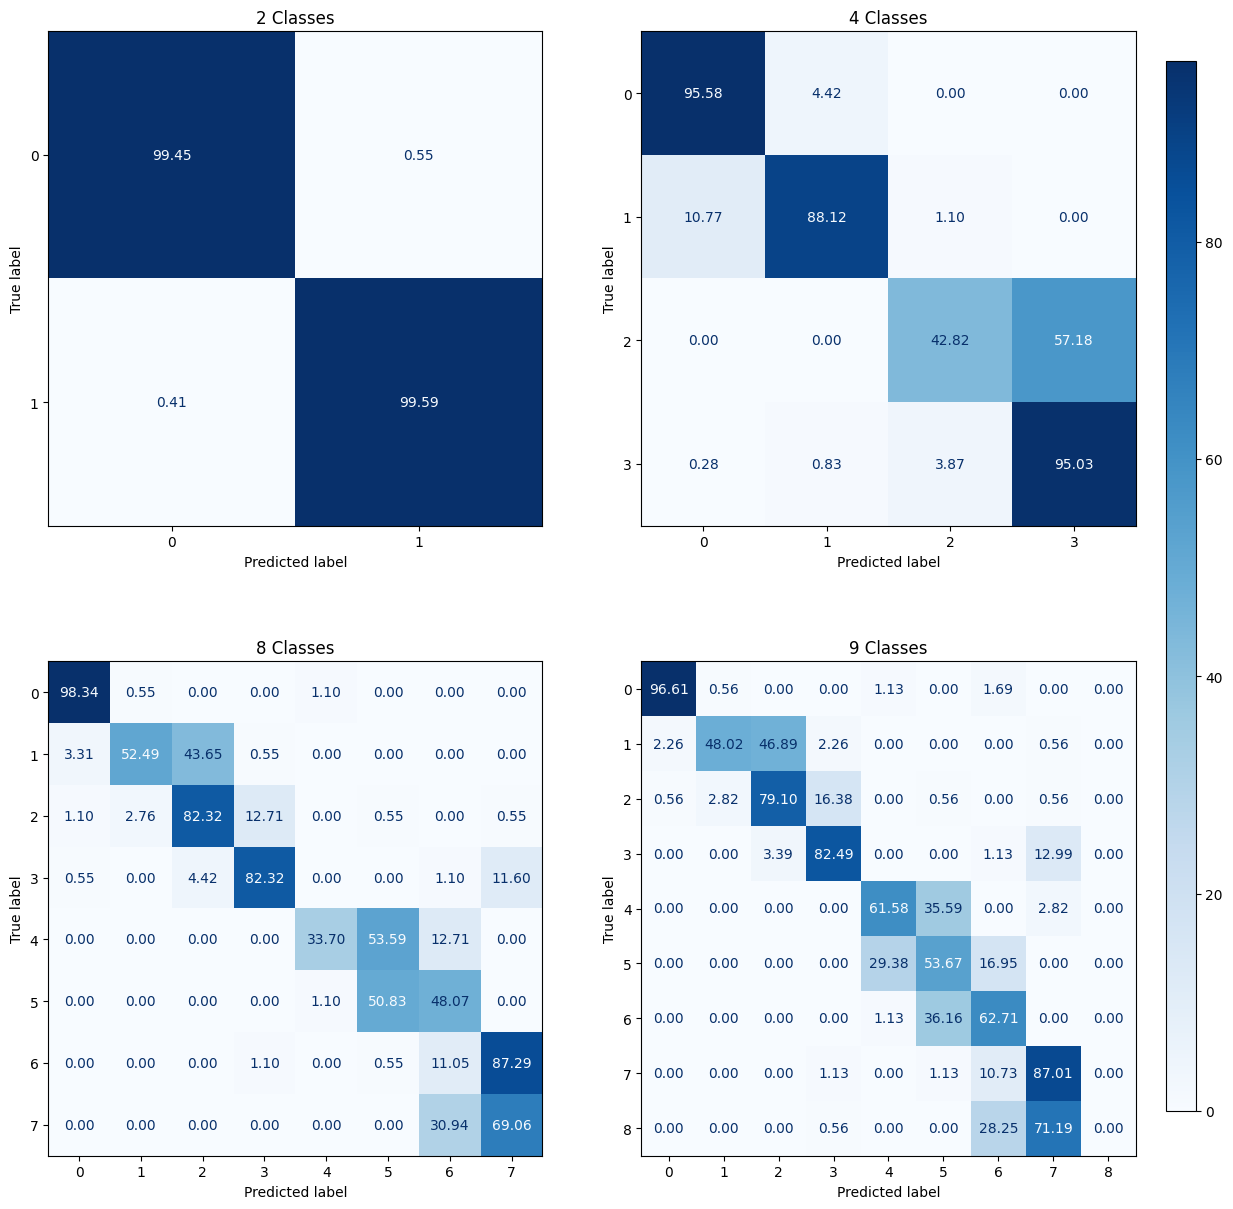

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])

# Define the titles and matrices
titles = ['2 Classes', '4 Classes', '8 Classes', '9 Classes']
matrices = [confusion_matrices['2'], confusion_matrices['4'], confusion_matrices['8'], confusion_matrices['9']]

for ax, matrix, title in zip(axes.flatten(), matrices, titles):
    # Normalize the confusion matrix by row
    cm_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    cm_percentage = cm_normalized * 100

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage)
    im = disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='.2f', colorbar=False)
    ax.set_title(title)

    # Add percentage symbol to the text annotations
    # for i in range(cm_percentage.shape[0]):
    #     for j in range(cm_percentage.shape[1]):
    #         ax.text(j, i, f'{cm_percentage[i, j]:.2f}%', ha='center', va='center', color='black')
    

# Add shared colorbar
fig.colorbar(im.im_, cax=cbar_ax)
plt.show()